# ASX Short Interest Signal

## Import Libraries

In [27]:
import pandas as pd
import datetime as dt
import tabula
import sys, subprocess
from pandas.tseries.offsets import BDay
import yfinance as yf
import time
import numpy as np
import tabula, concurrent.futures, functools
import concurrent.futures
import time, random, concurrent.futures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import warnings
import matplotlib.pyplot as plt


## Import Data
### Extracting and cleaning 52 weeks of ASX short interest data from ASIC. 

In [28]:
# --------- CONFIG ----------
WEEKS_TO_LOAD = 796
BASE = "https://download.asic.gov.au/short-selling/RR{datestr}-001-SSDailyAggShortPos.pdf"

# --------- Helpers ----------
def _norm_cols(cols):
    return [c.strip().lower().replace("\n", " ").replace("  ", " ") for c in cols]

def _num(s):
    return pd.to_numeric(pd.Series(s).astype(str).str.replace(",", "").str.strip(), errors="coerce")

def _is_ticker(x):
    """ASX tickers are 1–6 alphanumeric chars (allow '.'), no spaces."""
    if pd.isna(x): return False
    s = str(x).strip()
    if s.lower().startswith("product code"): return False
    if " " in s: return False
    return 1 <= len(s.replace(".", "")) <= 6 and s.replace(".", "").isalnum()

def _rename_clean_one(df):
    raw, norm = list(df.columns), _norm_cols(df.columns)
    cmap = {}
    for i, c in enumerate(norm):
        if c.startswith("product code"): cmap[raw[i]] = "Ticker"
        elif c.startswith("product"): cmap[raw[i]] = "Company"
        elif "reported short position" in c and "reported as short" not in c:
            cmap[raw[i]] = "Short Positions"
        elif "total product in issue" in c and "reported as short" not in c:
            cmap[raw[i]] = "Total Volume"
        elif "% of total product in issue reported as short positions" in c or c.endswith("short positions"):
            cmap[raw[i]] = "Shorts (%)"
    df = df.rename(columns=cmap)
    keep = ["Company","Ticker","Short Positions","Total Volume","Shorts (%)"]
    df = df[[c for c in keep if c in df.columns]].copy()
    if "Ticker" in df.columns:
        df = df[df["Ticker"].apply(_is_ticker)]
    if "Short Positions" in df.columns:
        df["Short Positions"] = _num(df["Short Positions"])
    if "Total Volume" in df.columns:
        df["Total Volume"] = _num(df["Total Volume"])
    if "Shorts (%)" in df.columns:
        df["Shorts (%)"] = pd.to_numeric(df["Shorts (%)"], errors="coerce")
    if "Shorts (%)" not in df.columns and {"Short Positions","Total Volume"}.issubset(df.columns):
        df["Shorts (%)"] = (df["Short Positions"] / df["Total Volume"]) * 100
    for col in keep:
        if col not in df.columns: df[col] = pd.NA
    return df[keep]

def _read_all_tables(url):
    for kw in (dict(lattice=True), dict(stream=True)):
        try:
            t = tabula.read_pdf(url, pages="all", multiple_tables=True, **kw)
            if t and len(t) > 0:
                return t
        except Exception:
            pass
    return []

def most_recent_friday(ref_date=None):
    if ref_date is None:
        ref_date = dt.date.today()
    offset = (ref_date.weekday() - 4) % 7
    return ref_date - dt.timedelta(days=offset)

def fetch_eow_for_friday(friday_date: dt.date, max_back_days=6) -> pd.DataFrame:
    for delta in range(0, max_back_days+1):
        day = friday_date - dt.timedelta(days=delta)
        ds = day.strftime("%Y%m%d")
        url = BASE.format(datestr=ds)
        tables = _read_all_tables(url)
        if not tables: continue
        cleaned = []
        for t in tables:
            if isinstance(t, pd.DataFrame) and len(t) >= 4 and len(t) > 0:
                cleaned.append(_rename_clean_one(t.dropna(how="all")))
        if not cleaned: continue
        out = pd.concat(cleaned, ignore_index=True).drop_duplicates()
        if not out.empty:
            release_dt = pd.to_datetime(ds, format="%Y%m%d")
            asof_dt = (release_dt - BDay(4)).normalize()
            out.insert(0, "Date", asof_dt)
            out.insert(1, "ReleaseDate", release_dt)
            return out
    return pd.DataFrame()

# --------- MAIN ----------
anchor_friday = most_recent_friday()
fridays = [anchor_friday - dt.timedelta(weeks=k) for k in range(WEEKS_TO_LOAD)]

with concurrent.futures.ThreadPoolExecutor(max_workers=6) as ex:
    frames = list(ex.map(fetch_eow_for_friday, fridays))

frames = [f for f in frames if not f.empty]
if not frames:
    raise RuntimeError("No ASIC EOW reports could be fetched. Check internet/Java (tabula).")

hist_df = (pd.concat(frames, ignore_index=True)
              .drop_duplicates(subset=["Date","Ticker"])
              .sort_values(["Date","Ticker"])
              .reset_index(drop=True))

# ---------- Filter: Keep only equities (ORDINARY shares) ----------
before = len(hist_df)
hist_df = hist_df[hist_df["Company"].str.contains("ORDINARY", case=False, na=False)]
after = len(hist_df)
print(f"Filtered out {before - after} non-ordinary securities (bonds, ETFs, hybrids).")

# ---------- Summary ----------
print(f"\nLoaded {hist_df['Date'].dt.date.nunique()} as-of dates, "
      f"{hist_df['Ticker'].nunique()} unique tickers, "
      f"{len(hist_df)} total rows (equities only).")

Filtered out 63104 non-ordinary securities (bonds, ETFs, hybrids).

Loaded 794 as-of dates, 2460 unique tickers, 370271 total rows (equities only).


In [29]:
# ---------- Preview ----------
print("\nPreview of cleaned ASIC short data:")
display(
    hist_df.tail(10)[
        ["Date", "ReleaseDate", "Ticker", "Company",
         "Short Positions", "Total Volume", "Shorts (%)"]
    ]
)


Preview of cleaned ASIC short data:


,Date,ReleaseDate,Ticker,Company,Short Positions,Total Volume,Shorts (%)
433358,2025-08-22,2025-08-28,WHC,WHITEHAVEN COAL ORDINARY,32688685,832423807,3.93
433359,2025-08-22,2025-08-28,WHK,WHITEHAWK LIMITED ORDINARY,69610,876984963,0.01
433360,2025-08-22,2025-08-28,WJL,WEBJET GROUP LIMITED ORDINARY,1603102,392530357,0.41
433361,2025-08-22,2025-08-28,WMG,WESTERN MINES ORDINARY,292,97188344,0.00
433362,2025-08-22,2025-08-28,WOR,WORLEY LIMITED ORDINARY,1154996,516038800,0.22
433363,2025-08-22,2025-08-28,WOW,WOOLWORTHS GROUP LTD ORDINARY,14474023,1221595333,1.18
433365,2025-08-22,2025-08-28,WTC,WISETECH GLOBAL LTD ORDINARY,4068174,334622986,1.22
433370,2025-08-22,2025-08-28,XRO,XERO LTD ORDINARY,1890673,165381624,1.14
433373,2025-08-22,2025-08-28,YAL,YANCOAL AUST LTD ORDINARY,33371106,1320439437,2.53
433374,2025-08-22,2025-08-28,ZIP,ZIP CO LTD.. ORDINARY,40428382,1290833227,3.13


### Add share price at release date and trading date as well as free float and SI (% of free float)

In [30]:
# ---------- Add Symbol + Normalized dates ----------
work = hist_df.copy()
work["Symbol"] = work["Ticker"].str.upper().str.strip() + ".AX"
work["Date_norm"] = pd.to_datetime(work["Date"]).dt.normalize()
work["ReleaseDate_norm"] = pd.to_datetime(work["ReleaseDate"]).dt.normalize()

syms = sorted(work["Symbol"].dropna().unique())
start = pd.to_datetime(work[["Date_norm","ReleaseDate_norm"]].min().min()) - pd.Timedelta(days=2)
end   = pd.to_datetime(work[["Date_norm","ReleaseDate_norm"]].max().max()) + pd.Timedelta(days=5)

# ---------- Float snapshot with fallback ----------
def _safe_float_info(sym: str) -> dict:
    out = {"Symbol": sym, "floatShares": np.nan, "sharesOutstanding": np.nan, "heldPercentInsiders": np.nan}
    try:
        tkr = yf.Ticker(sym)
        fi = getattr(tkr, "fast_info", None)
        if fi:
            out["floatShares"] = getattr(fi, "shares_float", np.nan)
            out["sharesOutstanding"] = getattr(fi, "shares_outstanding", np.nan)
        if pd.isna(out["floatShares"]) or pd.isna(out["sharesOutstanding"]):
            try:
                info = tkr.get_info()
            except Exception:
                info = getattr(tkr, "info", {}) or {}
            if info:
                fs = info.get("floatShares")
                so = info.get("sharesOutstanding") or info.get("impliedSharesOutstanding")
                hpi = info.get("heldPercentInsiders")
                if fs not in (None, ""):
                    out["floatShares"] = float(fs)
                if so not in (None, ""):
                    out["sharesOutstanding"] = float(so)
                if isinstance(hpi, (int, float)):
                    out["heldPercentInsiders"] = float(hpi)
    except Exception:
        pass
    return out

float_df = pd.DataFrame(_safe_float_info(s) for s in syms)
work = work.merge(float_df, on="Symbol", how="left")

# ---------- Free Float Estimate ----------
ff_from_insiders = work["sharesOutstanding"] * (1 - work["heldPercentInsiders"].fillna(0))
ff_candidates = pd.concat([work["floatShares"], ff_from_insiders], axis=1)
work["Date Free Float"] = ff_candidates.max(axis=1)

# ---------- Short Interest as % of free float ----------
m_ff = work["Short Positions"].notna() & work["Date Free Float"].gt(0)
work.loc[m_ff, "Shorts (Free Float %)"] = 100 * work.loc[m_ff, "Short Positions"] / work.loc[m_ff, "Date Free Float"]

# ---------- Price history (batch to reduce errors) ----------
batch_size = 50
price_frames = []
for i in range(0, len(syms), batch_size):
    batch = syms[i:i+batch_size]
    try:
        data = yf.download(
            batch,
            start=start.strftime("%Y-%m-%d"),
            end=end.strftime("%Y-%m-%d"),
            auto_adjust=False,
            progress=False,
            threads=True,
        )
        if "Close" in data.columns:   # Multi-ticker DataFrame
            data = data["Close"]
        elif isinstance(data, pd.Series):  # Single ticker fallback
            data = data.to_frame(name=batch[0])
        data.index = pd.to_datetime(data.index).normalize()
        price_frames.append(data)
        print(f"✓ Batch {i//batch_size+1}: {len(batch)} tickers")
    except Exception as e:
        print(f"⚠️ Batch {i//batch_size+1} failed: {e}")

if price_frames:
    prices = pd.concat(price_frames, axis=1).sort_index()
else:
    prices = pd.DataFrame()

# ---------- Align prices to Date & ReleaseDate ----------
asof_idx = pd.to_datetime(work["Date_norm"].unique())
rel_idx  = pd.to_datetime(work["ReleaseDate_norm"].unique())

asof_price = prices.reindex(asof_idx, method="bfill").stack().reset_index()
asof_price.columns = ["Date_norm","Symbol","Date Share Price"]

rel_price = prices.reindex(rel_idx, method="bfill").stack().reset_index()
rel_price.columns = ["ReleaseDate_norm","Symbol","Release Date Share Price"]

# ---------- Merge back ----------
hist_df = (work
    .merge(asof_price, on=["Date_norm","Symbol"], how="left")
    .merge(rel_price, on=["ReleaseDate_norm","Symbol"], how="left")
    .drop(columns=["Symbol","Date_norm","ReleaseDate_norm",
                   "floatShares","sharesOutstanding","heldPercentInsiders"])
    .sort_values(["Date","Ticker"])
    .reset_index(drop=True)
)

# ---------- Drop bad rows (require all critical fields) ----------
critical_cols = ["Date Share Price","Release Date Share Price","Date Free Float","Shorts (Free Float %)"]
hist_df = hist_df.dropna(subset=critical_cols)

# ---------- Preview ----------
print("Final cleaned dataset:")
print("Prices on Date:", hist_df["Date Share Price"].notna().sum(), "/", len(hist_df))
print("Prices on ReleaseDate:", hist_df["Release Date Share Price"].notna().sum(), "/", len(hist_df))
print("Free float present:", hist_df["Date Free Float"].notna().sum(), "/", len(hist_df))
print(">100% after fix:", (hist_df["Shorts (Free Float %)"] > 100).sum())

display(hist_df.head(12)[[
    "Date","ReleaseDate","Ticker","Company",
    "Short Positions","Total Volume","Shorts (%)",
    "Date Free Float","Shorts (Free Float %)",
    "Date Share Price","Release Date Share Price"
]])

HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 

17 Failed downloads:
['ABU.AX', '3DM.AX', 'AAX.AX', 'AAO.AX', 'AAE.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['9SP.AX', 'AB1.AX', 'ABC.AX', '2

✓ Batch 1: 50 tickers



14 Failed downloads:
['ADU.AX', 'AED.AX', 'AGF.AX', 'AFY.AX', 'ACG.AX', 'AEO.AX', 'AGK.AX', 'AEK.AX', 'AEJ.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['ACN.AX', 'AGJ.AX', 'ADA.AX', 'ADJ.AX', 'AFJ.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 2: 50 tickers



18 Failed downloads:
['AKK.AX', 'AHE.AX', 'AIO.AX', 'AIK.AX', 'AHD.AX', 'AIX.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['AKE.AX', 'AGS.AX', 'AJM.AX', 'AKI.AX', 'ALG.AX', 'ALF.AX', 'AHY.AX', 'AIR.AX', 'AHQ.AX', 'AJC.AX', 'AHG.AX', 'AHZ.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 3: 50 tickers



19 Failed downloads:
['AOC.AX', 'ALS.AX', 'APN.AX', 'AOE.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['AMG.AX', 'ANP.AX', 'AML.AX', 'AOU.AX', 'AOP.AX', 'APM.AX', 'AMB.AX', 'AMM.AX', 'APD.AX', 'AND.AX', 'ANA.AX', 'ALU.AX', 'ANW.AX', 'API.AX', 'APT.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 4: 50 tickers



13 Failed downloads:
['ATI.AX', 'ARW.AX', 'ASZ.AX', 'ARP.AX', 'APY.AX', 'AQP.AX', 'AQA.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['ARM.AX', 'ASO.AX', 'ATL.AX', 'ARE.AX', 'AST.AX', 'ARQ.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 5: 50 tickers



13 Failed downloads:
['AWB.AX', 'AXO.AX', 'AXA.AX', 'AVX.AX', 'AVO.AX', 'AXM.AX', 'AYN.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['AWC.AX', 'AYS.AX', 'AWV.AX', 'AVZ.AX', 'AUT.AX', 'AU8.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 6: 50 tickers



20 Failed downloads:
['AZX.AX', 'AZO.AX', 'AZZ.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['AZH.AX', 'AZM.AX', 'BAU.AX', 'BEM.AX', 'BBX.AX', 'BDA.AX', 'BAL.AX', 'BAT.AX', 'AZG.AX', 'BDC.AX', 'BAR.AX', 'BD1.AX', 'BDR.AX', 'AZT.AX', 'AZS.AX', 'B2Y.AX', 'BAF.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 7: 50 tickers



20 Failed downloads:
['BND.AX', 'BKN.AX', 'BIG.AX', 'BOM.AX', 'BPA.AX', 'BKP.AX', 'BLR.AX', 'BOW.AX', 'BMB.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['BLY.AX', 'BME.AX', 'BID.AX', 'BLK.AX', 'BLA.AX', 'BKL.AX', 'BIN.AX', 'BNO.AX', 'BLD.AX', 'BLT.AX', 'BGS.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 8: 50 tickers



21 Failed downloads:
['BRC.AX', 'BVA.AX', 'BTU.AX', 'BTV.AX', 'BYR.AX', 'BRM.AX', 'BTT.AX', 'BPS.AX', 'BRS.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['BRB.AX', 'BRV.AX', 'BTH.AX', 'BSE.AX', 'BST.AX', 'BYE.AX', 'BSR.AX', 'BUD.AX', 'BWX.AX', 'BZL.AX', 'BUL.AX', 'BSM.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 9: 50 tickers



19 Failed downloads:
['CCU.AX', 'CAH.AX', 'CCC.AX', 'CBX.AX', 'CEG.AX', 'CAB.AX', 'CBB.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['CAJ.AX', 'CAU.AX', 'CBR.AX', 'CDD.AX', 'CAS.AX', 'CDY.AX', 'CCZ.AX', 'CE1.AX', 'CAP.AX', 'CAI.AX', 'CDV.AX', 'CAD.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 10: 50 tickers



25 Failed downloads:
['CGG.AX', 'CHP.AX', 'CLL.AX', 'CGH.AX', 'CIR.AX', 'CIL.AX', 'CEY.AX', 'CIG.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['CLH.AX', 'CLT.AX', 'CGB.AX', 'CLI.AX', 'CGC.AX', 'CIM.AX', 'CFE.AX', 'CGA.AX', 'CLQ.AX', 'CHK.AX', 'CLF.AX', 'CL1.AX', 'CGN.AX', 'CJO.AX', 'CGL.AX', 'CHZ.AX', 'CGM.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 11: 50 tickers



21 Failed downloads:
['COZ.AX', 'COK.AX', 'CPS.AX', 'CNA.AX', 'CPB.AX', 'CPL.AX', 'CO1.AX', 'CNK.AX', 'CMV.AX', 'CMR.AX', 'COU.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['CPZ.AX', 'COE.AX', 'COO.AX', 'CNX.AX', 'CMA.AX', 'CPH.AX', 'CM8.AX', 'CNL.AX', 'CNW.AX', 'CNR.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 12: 50 tickers



18 Failed downloads:
['CR8.AX', 'CRZ.AX', 'CRE.AX', 'CUA.AX', 'CVO.AX', 'CQT.AX', 'CRK.AX', 'CWE.AX', 'CRH.AX', 'CRG.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['CVT.AX', 'CTX.AX', 'CSR.AX', 'CV1.AX', 'CRO.AX', 'CSV.AX', 'CSJ.AX', 'CRW.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 13: 50 tickers



17 Failed downloads:
['CYU.AX', 'CXB.AX', 'CZA.AX', 'CXS.AX', 'CXP.AX', 'CXY.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['DFM.AX', 'DCG.AX', 'DEG.AX', 'CWN.AX', 'DCN.AX', 'DAU.AX', 'CZI.AX', 'DDD.AX', 'DDH.AX', 'DEX.AX', 'CZL.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 14: 50 tickers



21 Failed downloads:
['DTE.AX', 'DOM.AX', 'DJS.AX', 'DML.AX', 'DRK.AX', 'DKN.AX', 'DRG.AX', 'DKO.AX', 'DSH.AX', 'DLS.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['DTQ.AX', 'DLC.AX', 'DLX.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['DRA.AX', 'DN8.AX', 'DRM.AX', 'DTC.AX', 'DTS.AX', 'DOU.AX', 'DGO.AX', 'DSE.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 15: 50 tickers



23 Failed downloads:
['EFG.AX', 'EGP.AX', 'ELM.AX', 'DYE.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['DWS.AX', 'E33.AX', 'EGO.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['EHE.AX', 'EAR.AX', 'ECX.AX', 'E2M.AX', 'EAS.AX', 'DW8.AX', 'EGN.AX', 'EEG.AX', 'EM1.AX', 'E2E.AX', 'ELX.AX', 'ELO.AX', 'DVN.AX', 'EGA.AX', 'EGS.AX', 'ELK.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 16: 50 tickers



19 Failed downloads:
['EPT.AX', 'EPG.AX', 'ESN.AX', 'EMX.AX', 'EUG.AX', 'ESG.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['EPW.AX', 'EUC.AX', 'ESH.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['EN1.AX', 'ESS.AX', 'ERW.AX', 'EPD.AX', 'ETE.AX', 'ESV.AX', 'ERX.AX', 'ENA.AX', 'ENE.AX', 'EP1.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 17: 50 tickers



18 Failed downloads:
['FGE.AX', 'EXE.AX', 'EZE.AX', 'FAN.AX', 'EXS.AX', 'FCR.AX', 'EXC.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['FFF.AX', 'FGL.AX', 'EXU.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['FFR.AX', 'FFT.AX', 'FGO.AX', 'EX1.AX', 'FDM.AX', 'FEO.AX', 'FEL.AX', 'FFX.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 18: 50 tickers



19 Failed downloads:
['FRR.AX', 'FSE.AX', 'G8C.AX', 'FTE.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['FXL.AX', 'FRSN.AX', 'FIG.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['FYI.AX', 'FOD.AX', 'FNT.AX', 'FNP.AX', 'FTZ.AX', 'FIJ.AX', 'FMS.AX', 'FYA.AX', 'FTD.AX', 'FSF.AX', 'FZO.AX', 'FTT.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 19: 50 tickers



23 Failed downloads:
['GMI.AX', 'GFF.AX', 'GIR.AX', 'GCS.AX', 'GEG.AX', 'GCL.AX', 'GDY.AX', 'GMM.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['GME.AX', 'GEV.AX', 'GMA.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['GDA.AX', 'GMV.AX', 'GMR.AX', 'GFE.AX', 'GGG.AX', 'GBG.AX', 'GFN.AX', 'GCY.AX', 'GCLN.AX', 'GBT.AX', 'GBP.AX', 'GLV.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 20: 50 tickers



15 Failed downloads:
['GTP.AX', 'GSC.AX', 'GOA.AX', 'GOT.AX', 'GRY.AX', 'GUF.AX', 'GRK.AX', 'GWT.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['GXL.AX', 'GUD.AX', 'GXY.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['GSW.AX', 'GPP.AX', 'GRB.AX', 'GNX.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 21: 50 tickers



16 Failed downloads:
['HIL.AX', 'HSO.AX', 'HOT.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['HLA.AX', 'HHI.AX', 'HIG.AX', 'HRR.AX', 'HLSNB.AX', 'HNR.AX', 'HHY.AX', 'HT1.AX']: YFTzMissingError('possibly delisted; no timezone found')
['HFA.AX', 'HUN.AX', 'HEG.AX', 'HSP.AX', 'HOM.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')


✓ Batch 22: 50 tickers



16 Failed downloads:
['IFZ.AX', 'IDG.AX', 'IIL.AX', 'IFE.AX', 'IIN.AX', 'IBY.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['IAU.AX', 'HUO.AX', 'IHL.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['IHR.AX', 'ICQ.AX', 'HXG.AX', 'IAP.AX', 'IBG.AX', 'HYM.AX', 'IKW.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 23: 50 tickers



20 Failed downloads:
['ISN.AX', 'ISF.AX', 'IRN.AX', 'IQE.AX', 'IOH.AX', 'IPP.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['ISX.AX', 'INP.AX', 'IPL.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['IP1.AX', 'IMF.AX', 'IOU.AX', 'ISU.AX', 'IVO.AX', 'ISD.AX', 'IOT.AX', 'IVC.AX', 'INL.AX', 'ITG.AX', 'IMS.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 24: 50 tickers



16 Failed downloads:
['JRV.AX', 'JRL.AX', 'KAS.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['JHC.AX', 'KIS.AX', 'KGM.AX', 'JHL.AX', 'KIN.AX', 'KIL.AX', 'KDR.AX', 'JXT.AX', 'JDR.AX', 'IXU.AX', 'KFE.AX']: YFTzMissingError('possibly delisted; no timezone found')
['JML.AX', 'JAG.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')


✓ Batch 25: 50 tickers



17 Failed downloads:
['KRC.AX', 'KSO.AX', 'KZL.AX', 'LDW.AX', 'LEI.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['LCT.AX', 'LBY.AX', 'LCM.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['LCK.AX', 'KTD.AX', 'LBT.AX', 'LAA.AX', 'KZA.AX', 'LER.AX', 'KYK.AX', 'KWR.AX', 'KNL.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 26: 50 tickers



10 Failed downloads:
['LMR.AX', 'LFR.AX', 'LRC.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['LNK.AX', 'LLI.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['LRS.AX', 'LNG.AX', 'LRL.AX', 'LPI.AX', 'LON.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 27: 50 tickers



18 Failed downloads:
['MCU.AX', 'LWP.AX', 'MAE.AX', 'MCS.AX', 'MBE.AX', 'MBN.AX', 'MCC.AX', 'MAK.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['MCT.AX', 'MCR.AX', 'MEB.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['LV1.AX', 'MCL.AX', 'ME1.AX', 'MAI.AX', 'LYN.AX', 'MEA.AX', 'LVH.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 28: 50 tickers



19 Failed downloads:
['MEO.AX', 'MKB.AX', 'MIZ.AX', 'MLB.AX', 'MGO.AX', 'MLI.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['MLT.AX', 'MEP.AX', 'MGG.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['MKG.AX', 'MIL.AX', 'MEY.AX', 'MGC.AX', 'MHH.AX', 'MLM.AX', 'MGV.AX', 'MMJ.AX', 'MLD.AX', 'MLL.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 29: 50 tickers



27 Failed downloads:
['MMW.AX', 'MSF.AX', 'MQA.AX', 'MRU.AX', 'MMX.AX', 'MOL.AX', 'MOX.AX', 'MOS.AX', 'MOO.AX', 'MNM.AX', 'MNQ.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['MOC.AX', 'MOQ.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['MSM.AX', 'MNY.AX', 'MNF.AX', 'MOD.AX', 'MRP.AX', 'MOE.AX', 'MSR.AX', 'MR1.AX', 'MNW.AX', 'MOY.AX', 'MRM.AX', 'MSL.AX', 'MRG.AX', 'MOB.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 30: 50 tickers



23 Failed downloads:
['NAD.AX', 'NBS.AX', 'MUM.AX', 'MTU.AX', 'MUS.AX', 'MUX.AX', 'MTE.AX', 'MYT.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['MYD.AX', 'MZZ.AX', 'MXR.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['MYQ.AX', 'NBL.AX', 'MZI.AX', 'MTR.AX', 'NBI.AX', 'MWR.AX', 'MYL.AX', 'MXC.AX', 'NCZ.AX', 'NCM.AX', 'MYO.AX', 'MWY.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 31: 50 tickers



18 Failed downloads:
['NPX.AX', 'NFE.AX', 'NRL.AX', 'NRT.AX', 'NEN.AX', 'NSL.AX', 'NQM.AX', 'NFK.AX', 'NGF.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['NKL.AX', 'NSE.AX', 'NOC.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['NTC.AX', 'NEA.AX', 'NML.AX', 'NHL.AX', 'NMS.AX', 'NEW.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 32: 50 tickers



17 Failed downloads:
['NYO.AX', 'NWZ.AX', 'NXR.AX', 'OBS.AX', 'NWT.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['OBJ.AX', 'OEG.AX', 'NTO.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['NWE.AX', 'NZO.AX', 'OAR.AX', 'NZC.AX', 'OCP.AX', 'NVT.AX', 'OEX.AX', 'NVL.AX', 'NUS.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 33: 50 tickers



22 Failed downloads:
['OKN.AX', 'OMI.AX', 'OMT.AX', 'OST.AX', 'OZB.AX', 'OTC.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['OKU.AX', 'OMN.AX', 'ORR.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['OGH.AX', 'OSH.AX', 'PAA.AX', 'OVH.AX', 'ONT.AX', 'PAL.AX', 'OPY.AX', 'OKR.AX', 'OZL.AX', 'OPC.AX', 'OTW.AX', 'OPA.AX', 'OVN.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 34: 50 tickers



19 Failed downloads:
['PCP.AX', 'PDY.AX', 'PEP.AX', 'PBG.AX', 'PFL.AX', 'PBD.AX', 'PHG.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['PBP.AX', 'PGX.AX', 'PBT.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['PF1.AX', 'PGI.AX', 'PGG.AX', 'PDL.AX', 'PEA.AX', 'PDZ.AX', 'PG1.AX', 'PGR.AX', 'PGL.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 35: 50 tickers



14 Failed downloads:
['PHK.AX', 'PPX.AX', 'PMP.AX', 'POK.AX', 'PLV.AX', 'PNA.AX', 'PIR.AX', 'PPP.AX', 'PRA.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['PNL.AX', 'POH.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['PIO.AX', 'POS.AX', 'PMY.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 36: 50 tickers



16 Failed downloads:
['PRC.AX', 'PXG.AX', 'PRY.AX', 'PSY.AX', 'PSP.AX', 'PRR.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['PTB.AX', 'PRT.AX', 'QHL.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['PTG.AX', 'PXS.AX', 'PVD.AX', 'PSA.AX', 'PWL.AX', 'PSI.AX', 'PYR.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 37: 50 tickers



17 Failed downloads:
['RDR.AX', 'QMN.AX', 'RCG.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['RCW.AX', 'RES.AX', 'RCP.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['REF.AX', 'RAP.AX', 'RE1.AX', 'QIP.AX', 'RDT.AX', 'QMS.AX', 'RDH.AX', 'RBL.AX', 'QRN.AX', 'RDF.AX', 'RED.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 38: 50 tickers



20 Failed downloads:
['RIV.AX', 'RNI.AX', 'ROL.AX', 'RPX.AX', 'ROY.AX', 'RNS.AX', 'RGX.AX', 'RIA.AX', 'RHG.AX', 'RFE.AX', 'RFL.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['ROS.AX', 'RGI.AX', 'RHP.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['RFN.AX', 'RLE.AX', 'RHL.AX', 'RMP.AX', 'RNE.AX', 'RQL.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 39: 50 tickers



21 Failed downloads:
['SBL.AX', 'SAI.AX', 'SEV.AX', 'RUM.AX', 'SDM.AX', 'RWH.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['RXP.AX', 'SEA.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['SES.AX', 'SCL.AX', 'SE1.AX', 'SF1.AX', 'SCU.AX', 'RVR.AX', 'SDG.AX', 'RSH.AX', 'RRS.AX', 'SAS.AX', 'SAR.AX', 'SDA.AX', 'RXM.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 40: 50 tickers



15 Failed downloads:
['SFH.AX', 'SFW.AX', 'SKB.AX', 'SKE.AX', 'SIR.AX', 'SIP.AX', 'SGN.AX', 'SFZ.AX', 'SLV.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['SLR.AX', 'SLK.AX', 'SIH.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['SKF.AX', 'SI6.AX', 'SGF.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 41: 50 tickers



13 Failed downloads:
['SNY.AX', 'SRQ.AX', 'SOO.AX', 'SPH.AX', 'SRM.AX', 'SPI.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['SPO.AX', 'SRS.AX', 'SO4.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['SOV.AX', 'SPM.AX', 'SRX.AX', 'SPT.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 42: 50 tickers



16 Failed downloads:
['SWL.AX', 'STB.AX', 'SWW.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['SWK.AX', 'SXY.AX', 'SWF.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['STC.AX', 'TAP.AX', 'SVW.AX', 'SUR.AX', 'SVH.AX', 'SYM.AX', 'SUV.AX', 'SYT.AX', 'SXG.AX', 'SUD.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 43: 50 tickers



20 Failed downloads:
['TCH.AX', 'TEN.AX', 'TFC.AX', 'TIX.AX', 'TEL.AX', 'TIM.AX', 'TFG.AX', 'TCM.AX', 'TIS.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['TDI.AX', 'THC.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['TIE.AX', 'TMR.AX', 'TGR.AX', 'TGG.AX', 'TMT.AX', 'TBH.AX', 'THX.AX', 'TME.AX', 'TGA.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 44: 50 tickers



28 Failed downloads:
['TTS.AX', 'TTY.AX', 'TSE.AX', 'TTN.AX', 'TPN.AX', 'TTW.AX', 'TSV.AX', 'TRG.AX', 'TSM.AX', 'TPI.AX', 'TOF.AX', 'TPT.AX', 'TOL.AX', 'TRO.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['TSC.AX', 'TSN.AX', 'TRT.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['TNG.AX', 'TPM.AX', 'TPD.AX', 'TNT.AX', 'TNO.AX', 'TTB.AX', 'TNK.AX', 'TPE.AX', 'TRY.AX', 'TNR.AX']: YFTzMissingError('possibly delisted; no timezone found')
['TRS.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02) (Yahoo error = "No data found, symbol may be delisted")')


✓ Batch 45: 50 tickers



21 Failed downloads:
['UML.AX', 'UXC.AX', 'VET.AX', 'UNX.AX', 'UGL.AX', 'VGH.AX', 'VEI.AX', 'VBA.AX', 'VED.AX', 'UXA.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['VAN.AX', 'VGI.AX', 'VAH.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['UMG.AX', 'VG8.AX', 'VAL.AX', 'TV2.AX', 'TYM.AX', 'UWL.AX', 'VHT.AX', 'VEC.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 46: 50 tickers



19 Failed downloads:
['VRE.AX', 'VPE.AX', 'WAN.AX', 'VWM.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['VIC.AX', 'VMY.AX', 'VLT.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['VLW.AX', 'VOL.AX', 'VRT.AX', 'VTG.AX', 'VTH.AX', 'VMS.AX', 'VIRDA.AX', 'VOR.AX', 'VOC.AX', 'VXR.AX', 'VPC.AX', 'VMX.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 47: 50 tickers



22 Failed downloads:
['WHN.AX', 'WDR.AX', 'WCP.AX', 'WCB.AX', 'WMN.AX', 'WHG.AX', 'WHS.AX', 'WHE.AX', 'WCL.AX', 'WFM.AX', 'WAS.AX', 'WBB.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['WLF.AX', 'WHA.AX', 'WMC.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['WND.AX', 'WJA.AX', 'WGO.AX', 'WGF.AX', 'WBA.AX', 'WCG.AX', 'WLL.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 48: 50 tickers



21 Failed downloads:
['WTF.AX', 'YTC.AX', 'XXL.AX', 'WVL.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['Z2U.AX', 'XIP.AX', 'WRM.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['XTE.AX', 'WPP.AX', 'WSP.AX', 'WPL.AX', 'XPE.AX', 'ZEL.AX', 'WPG.AX', 'Z1P.AX', 'XTD.AX', 'YBR.AX', 'WNI.AX', 'ZEN.AX', 'WSA.AX', 'YFZ.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 49: 50 tickers



4 Failed downloads:
['ZML.AX', 'ZYL.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['ZER.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['ZNZ.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 50: 10 tickers
Final cleaned dataset:
Prices on Date: 226643 / 226643
Prices on ReleaseDate: 226643 / 226643
Free float present: 226643 / 226643
>100% after fix: 553


,Date,ReleaseDate,Ticker,Company,Short Positions,Total Volume,Shorts (%),Date Free Float,Shorts (Free Float %),Date Share Price,Release Date Share Price
70,2010-06-14,2010-06-18,CDU,CUDECO LIMITED ORDINARY,753797,137285632,0.56,3.942780e+08,0.191184,3.769556,3.999304
199,2010-06-14,2010-06-18,MPO,MOLOPO ENERGY LTD ORDINARY,11281,250665548,0.00,2.490410e+08,0.004530,1.055000,1.140000
268,2010-06-14,2010-06-18,SDL,SUNDANCE RESOURCES ORDINARY,18973425,2709995932,0.69,9.450020e+09,0.200777,0.130000,0.130000
335,2010-06-21,2010-06-25,AAC,AUSTRALIAN AGRICULT. ORDINARY,5383914,264264459,2.04,1.358456e+08,3.963259,1.429103,1.410299
339,2010-06-21,2010-06-25,ACR,ACRUX LIMITED ORDINARY,123421,160556216,0.07,3.357520e+08,0.036760,1.875000,1.830000
340,2010-06-21,2010-06-25,ADD,ADAVALE RESOURCE LTD ORDINARY,138644,183593979,0.08,1.478351e+08,0.093783,11.270823,11.997972
349,2010-06-21,2010-06-25,AIA,AUCKLAND INTERNATION ORDINARY,54,1310392831,0.00,1.687687e+09,0.000003,1.738888,1.716666
350,2010-06-21,2010-06-25,AIQ,ALTERNATIVE INVEST ORDINARY UNITS,15000,130692470,0.01,1.893081e+07,0.079236,1.030000,1.035000
352,2010-06-21,2010-06-25,AJL,AJ LUCAS GROUP ORDINARY,423513,65276374,0.65,1.216613e+09,0.034811,1.739718,1.567127
353,2010-06-21,2010-06-25,ALL,ARISTOCRAT LEISURE ORDINARY,19286065,533379348,3.61,5.535938e+08,3.483794,3.944195,3.715113


## Adding Signals
- **mom_12w**  
  *12-week momentum.*  
  The percentage return of the share price over the last 12 weeks. Positive momentum means the stock has been trending upwards; negative means downwards.

- **si_percentile_52w**  
  *Short interest percentile (52 weeks).*  
  Where the current short interest (% of free float) ranks compared to the last 52 weeks.  
  - Value near 1.0 → current SI is very high relative to history.  
  - Value near 0.0 → current SI is very low relative to history.

- **si_up_weeks**  
  *Persistence of short builds.*  
  Number of the past 5 weeks where short interest increased.  
  - Higher values indicate consistent short builds.  
  - Used as a persistence signal (e.g., 4/5 weeks up = strong conviction).

- **mom_si_interact**  
  *Momentum × Short interest interaction.*  
  A combined factor capturing when **momentum is negative (price falling)** *and* **short interest is high or rising**.  
  This interaction often points to stocks under pressure from both technicals and positioning.

- **vol_4w**  
  *4-week realized volatility.*  
  The standard deviation of weekly returns over the past 4 weeks.  
  Indicates how volatile the stock has been recently; higher volatility may amplify short opportunities.


In [61]:
# ---------- Build Signals ----------
def build_signals(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    g = df.groupby("Ticker", group_keys=False)

    # --- 1. Momentum (12-week return)
    df["mom_12w"] = g["Date Share Price"].transform(lambda x: x.pct_change(periods=12))

    # --- 2. Short interest percentile (52 weeks)
    def rolling_percentile(x, window=52):
        return x.rolling(window, min_periods=12).apply(
            lambda s: pd.Series(s).rank(pct=True).iloc[-1], raw=False
        )
    df["si_percentile_52w"] = g["Shorts (Free Float %)"].transform(rolling_percentile)

    # --- 3. Persistence of SI build (count of up weeks in last 5)
    def count_up_weeks(x):
        return x.diff().gt(0).rolling(5, min_periods=3).sum()
    df["si_up_weeks"] = g["Shorts (Free Float %)"].transform(count_up_weeks)

    # --- 4. Interaction: momentum × SI
    df["mom_si_interact"] = df["mom_12w"] * df["Shorts (Free Float %)"]

    # --- 5. Volatility (4-week rolling std of returns)
    df["ret_1w"] = g["Date Share Price"].transform(lambda x: x.pct_change(periods=1))
    df["vol_4w"] = g["ret_1w"].transform(lambda x: x.rolling(4, min_periods=3).std())

    return df

# ---------- Apply ----------
signals_df = build_signals(hist_df)

# ---------- Preview ----------
display(signals_df.tail(12)[[
    "Date", "Ticker", "Date Share Price", "Shorts (Free Float %)",
    "mom_12w", "si_percentile_52w", "si_up_weeks",
    "mom_si_interact", "vol_4w"
]])


,Date,Ticker,Date Share Price,Shorts (Free Float %),mom_12w,si_percentile_52w,si_up_weeks,mom_si_interact,vol_4w
370259,2025-08-22,WES,94.629997,0.572624,0.144949,0.384615,3.0,0.083001,0.012319
370260,2025-08-22,WGX,3.220000,3.059242,0.091525,0.711538,3.0,0.279998,0.078503
370261,2025-08-22,WHC,6.530000,4.136133,0.193784,0.519231,2.0,0.801518,0.058172
370262,2025-08-22,WHK,0.010000,0.010707,-0.285714,0.509615,0.0,-0.003059,0.101236
370263,2025-08-22,WJL,0.940000,0.630144,0.068182,0.086957,0.0,0.042964,0.038768
370264,2025-08-22,WMG,0.235000,0.000441,0.270270,0.425000,1.0,0.000119,0.112205
370265,2025-08-22,WOR,12.910000,0.239914,-0.008449,0.038462,2.0,-0.002027,0.010893
370266,2025-08-22,WOW,33.119999,1.188328,0.038570,1.000000,4.0,0.045834,0.007312
370267,2025-08-22,WTC,112.589996,2.190222,0.074845,0.884615,1.0,0.163927,0.029306
370268,2025-08-22,XRO,167.979996,1.176481,-0.074337,0.288462,1.0,-0.087457,0.022372


## Train model to determine best score
*Lasso Regression*  
Lorem ipsum

In [71]:
# %% ===== 4) Walk-forward loop (exit-week returns only) =====
pred_rows, weekly_equity, all_trades = [], [], []
t0 = time.time()

for i in range(loop_start, total_weeks):
    if dates[i] < trade_start_date:
        continue

    # --- Training window ---
    train_start = dates[i - TRAIN_WEEKS]
    train_end   = dates[i - 1]
    test        = panel[panel["Date"] == dates[i]]

    train = panel[(panel["Date"] >= train_start) & (panel["Date"] <= train_end)]
    if (len(train) < MIN_TRAIN_SAMPLES) or test.empty:
        continue

    # --- Fit logistic model ---
    Xtr, ytr = train[ZCOLS].values, train["y_down"].astype(int).values
    final = LogisticRegression(
        penalty=PENALTY, solver=SOLVER,
        C=C_FIXED, max_iter=1000, fit_intercept=True,
        class_weight="balanced"
    )
    final.fit(Xtr, ytr)

    # --- Predict TRAIN to tune threshold ---
    train_snap = train[["Date","Ticker","short_ret_sl"]].copy()
    train_snap["prob_down"] = final.predict_proba(train[ZCOLS].values)[:, 1]
    train_snap["score"] = train_snap.groupby("Date")["prob_down"].transform(_cs_z)

    # --- Throttle check ---
    eq_df = pd.DataFrame(weekly_equity) if weekly_equity else pd.DataFrame(columns=["date","period_ret"])
    throttle_on, trailing_cum = apply_perf_throttle(eq_df)

    cap_base = 15
    cap_use  = max(MIN_CAP_WHEN_THROTTLED, int(cap_base * THROTTLE_CAP_MULT)) if throttle_on else cap_base

    # --- Tune probability threshold ---
    pr_use, tune_stats = choose_prob_threshold(train_snap, cap_use=cap_use, val_weeks=26)
    if throttle_on:
        pr_use = min(0.999, pr_use + THROTTLE_PROB_UP)

    # --- Predict TEST week ---
    snap = test[["Date","Ticker"]].copy()
    snap["prob_down"] = final.predict_proba(test[ZCOLS].values)[:, 1]
    mu, sd = snap["prob_down"].mean(), snap["prob_down"].std(ddof=0)
    snap["score"] = (snap["prob_down"] - mu) / (sd if sd > 0 else 1.0)
    snap = snap.sort_values("score", ascending=False).reset_index(drop=True)
    snap["rank_in_week"] = snap["score"].rank(method="first", ascending=False)

    snap["enter_short"] = (snap["prob_down"] >= pr_use) & (snap["rank_in_week"] <= cap_use)
    snap["throttle_on"]   = throttle_on
    snap["trailing_cum"]  = trailing_cum
    snap["cap_use"]       = cap_use
    snap["p_thresh_used"] = pr_use
    pred_rows.append(snap)

    # --- Build trade rows for each entry ---
    trade_rows = []
    for _, pick in snap[snap["enter_short"]].iterrows():
        tkr = pick["Ticker"]
        g = panel[panel["Ticker"] == tkr].sort_values("Date").reset_index(drop=True)

        idx = g[g["Date"] == dates[i]].index
        if len(idx) == 0:
            continue
        idx = idx[0]

        entry_price = g.loc[idx, "Date Share Price"]
        exit_idx    = idx + 4
        exit_price  = g.loc[exit_idx, "Date Share Price"] if exit_idx in g.index else np.nan

        if pd.notna(entry_price) and pd.notna(exit_price) and entry_price != 0:
            ret = (entry_price - exit_price) / entry_price  # short return
            trade_rows.append({
                "Ticker": tkr,
                "entry_date": dates[i],
                "exit_date": dates[i] + np.timedelta64(28, "D"),
                "entry_price": entry_price,
                "exit_price": exit_price,
                "realized_ret": ret
            })

    if trade_rows:
        all_trades.append(pd.DataFrame(trade_rows))

    # --- Calculate returns for trades EXITING this week ---
    exiting = []
    for df in all_trades:
        wk = df[df["exit_date"] == dates[i]]
        if not wk.empty:
            exiting.append(wk["realized_ret"].mean())

    week_ret = np.mean(exiting) if exiting else 0.0

    weekly_equity.append({
        "date": dates[i],
        "period_ret": week_ret  # avg of trades that EXIT this week
    })

print("Loop runtime:", round(time.time()-t0,2), "seconds")

# %% ===== 5) Outputs =====
preds  = pd.concat(pred_rows, ignore_index=True) if pred_rows else pd.DataFrame()
eq     = pd.DataFrame(weekly_equity)
trades = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame()

# --- Compound cumulative return from exited trades ---
if not eq.empty:
    eq = eq.sort_values("date").reset_index(drop=True)
    eq["cum_ret"] = (1 + eq["period_ret"]).cumprod() - 1

print(f"\nTrade window: {trade_start_date.date()} → {trade_end_date.date()}  ({len(eq)} weeks)")
if not eq.empty:
    print(f"Final cumulative return: {(eq['cum_ret'].iloc[-1]*100):.2f}%")
    avg_names = preds.groupby("Date")["enter_short"].sum().mean() if not preds.empty else 0.0
    print(f"Avg names/week: {avg_names:.1f}")
    pr_series = preds.drop_duplicates("Date")[["Date","p_thresh_used","cap_use","throttle_on"]].sort_values("Date")
    print("Latest p* used:", pr_series.iloc[-1].to_dict() if not pr_series.empty else {})


Loop runtime: 58.11 seconds

Trade window: 2021-05-03 → 2025-07-28  (173 weeks)
Final cumulative return: -1007.21%
Avg names/week: 2.3
Latest p* used: {'Date': Timestamp('2025-07-28 00:00:00'), 'p_thresh_used': 0.625, 'cap_use': 15, 'throttle_on': False}


## Results
### Graph

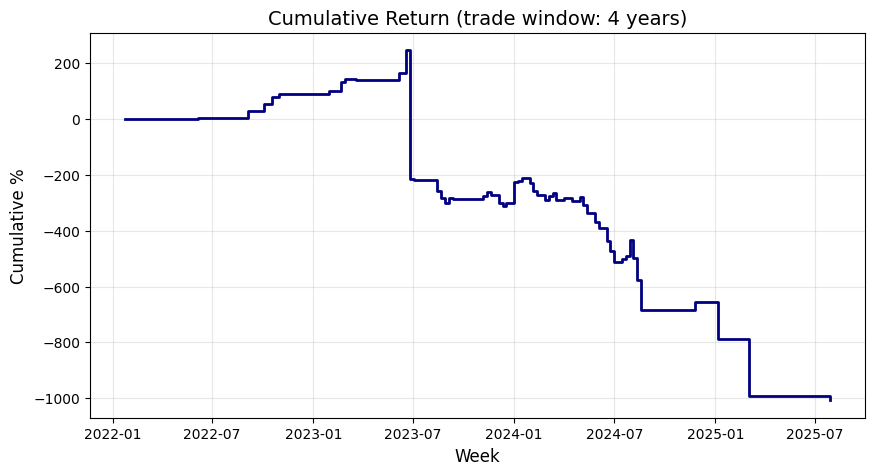

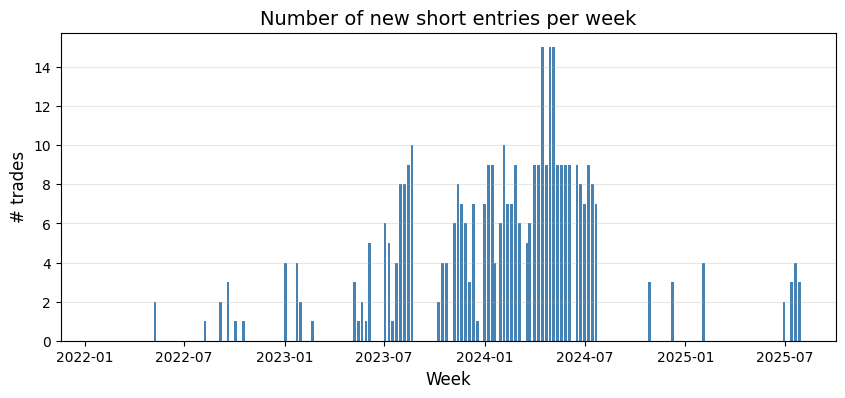

In [72]:
# ---- Plot equity curve (step-style, no dots) ----
if not eq.empty:
    fig, ax = plt.subplots(figsize=(10,5))

    # Use step plot so equity is flat until the next trade exit
    ax.step(eq["date"], eq["cum_ret"]*100, where="post", linewidth=2, color="navy")

    ax.set_title(f"Cumulative Return (trade window: {TRADE_YEARS} years)", fontsize=14)
    ax.set_ylabel("Cumulative %", fontsize=12)
    ax.set_xlabel("Week", fontsize=12)
    ax.grid(True, alpha=0.3)

    plt.show()

# ---- Plot number of entries per week ----
if not preds.empty:
    by_w = preds.groupby("Date")["enter_short"].sum().reset_index(name="num_entries")

    fig, ax = plt.subplots(figsize=(10,4))
    ax.bar(by_w["Date"], by_w["num_entries"], color="steelblue", width=5)

    ax.set_title("Number of new short entries per week", fontsize=14)
    ax.set_ylabel("# trades", fontsize=12)
    ax.set_xlabel("Week", fontsize=12)
    ax.grid(True, alpha=0.3, axis="y")

    plt.show()


In [68]:
# ---------- Build trade check table for ALL executed trades ----------
trade_checks = []

if not trades.empty:
    for _, row in trades.iterrows():
        tkr   = row["Ticker"]
        entry = row["entry_date"]

        g = panel[panel["Ticker"] == tkr].sort_values("Date").reset_index(drop=True)

        idx = g.index[g["Date"] == entry]
        if len(idx) == 0:
            continue
        idx = idx[0]

        entry_price = g.loc[idx, "Date Share Price"]

        # require an exit price 4 rows ahead
        if idx + 4 < len(g):
            exit_price = g.loc[idx + 4, "Date Share Price"]
        else:
            continue   # <-- SKIP if no exit price available

        realized_ret = row.get("realized_ret", np.nan)

        realized_ret_check = np.nan
        if pd.notna(entry_price) and pd.notna(exit_price) and entry_price != 0:
            realized_ret_check = (entry_price - exit_price) / entry_price

        trade_checks.append({
            "entry_date": row["entry_date"],
            "exit_date": row["exit_date"],
            "Ticker": tkr,
            "entry_price": entry_price,
            "exit_price": exit_price,
            "realized_ret": realized_ret,
            "realized_ret_check": realized_ret_check
        })

trade_check_table = pd.DataFrame(trade_checks)
display(trade_check_table.tail(50))


,entry_date,exit_date,Ticker,entry_price,exit_price,realized_ret,realized_ret_check
208,2024-06-24,2024-07-22,DXN,0.067000,0.085,-0.100000,-0.268657
209,2024-06-24,2024-07-22,88E,0.075000,0.050,0.333333,0.333333
210,2024-06-24,2024-07-22,ENR,0.620000,0.560,0.096774,0.096774
211,2024-06-24,2024-07-22,RDN,0.026000,0.025,0.038462,0.038462
212,2024-06-24,2024-07-22,FAL,0.265000,0.325,-0.100000,-0.226415
213,2024-06-24,2024-07-22,HGO,0.065000,0.067,-0.030769,-0.030769
214,2024-06-24,2024-07-22,GDG,2.380000,2.770,-0.100000,-0.163865
215,2024-07-01,2024-07-29,DXN,0.070000,0.074,-0.057143,-0.057143
216,2024-07-01,2024-07-29,88E,0.050000,0.075,-0.100000,-0.500000
217,2024-07-01,2024-07-29,ENR,0.780000,0.650,0.166667,0.166667
